# The Forest-fire model
adapted from https://scipython.com/blog/the-forest-fire-model/


A simple model of a forest fire is defined as a two-dimensional cellular automaton on a grid of cells which take one of three states: empty, occupied by a tree, or burning. The automaton evolves according to the following rules which are executed simultaneously for every cell at a given generation.

- A burning cell turns into an empty cell
- A cell occupied by a tree becomes a burning cell if any of its eight neighbouring cells are burning
- A cell occupied by a tree becomes burning with a probabilty f (even if none of its neighbouring cells are burning), as though struck by lightning
- An empty cell becomes occupied by a tree with probability p.

The model is interesting as a simple dynamical system displaying self-organized criticality. 
One of the characteristic traits of self organized critical systems, is that they will show a power law distribution of event sizes.
https://en.wikipedia.org/wiki/Power_law



## Implementation
The following Python code simulates multiple forest fires and forest regrowth.
You can modify the behaviour of the model by adapting the `ffm_step` function.

### imports

Some useful module are imported a the beginning of the execution. 
An couple of utility functions are located in the package `utils.ffm_utils` and are used to visualize the simulation as a movie after running the model.
The command `%matplotlib inline` (which is called a notebook [**magic**](https://ipython.readthedocs.io/en/stable/interactive/magics.html)) is used to plot the graphs inline in the notebook interface. 

We also define some useful constants.

In [63]:
import numpy as np
from numpy.random import random
from utils.ffm_utils import run_simulation
from matplotlib import pyplot as plt
# set the default figure size for all the plots
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
%matplotlib inline

# simulation constants
NEIGHBOROOD = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
EMPTY, TREE, FIRE = 0, 1, 2

## Setting the parameters

You can modify the content of the next cell to modify the parameters of the simulation

In [6]:
# The initial fraction of the forest occupied by trees.
forest_fraction = 0.2
# Probability of new tree growth per empty cell, and of lightning strike.
p, f = 0.05, 0.01
# Forest size (number of cells in x and y directions).
nx, ny = 100, 100

# number of frames of simulation
n_frames = 100

## Model implementation

In this cell we define the function `ffm_step` that will be called repeatetly by the the `run_simulation`.
You can modify the model by changing this function. The working matrix `X` will be updated and returned to the the caller function.

In [7]:
run_simulation?

Signature: run_simulation(X, n_frames, grow_func, ignite_func, burn_func)
Docstring:
calls the function "grow_func", "ignite_func" and "burn_func" on X n_frames times.
Overwrites the X matrice, and plots the result as animation.
Returns a list of wildfire burned area for each iteration.
File:      ~/didattica/unige-wram-2018/notebooks/utils/ffm_utils.py
Type:      function


In [8]:
# list on which the dimension of every fire will be saved
tot_fires = []

def grow(X):
    """Iterate the forest according to the forest-fire rules."""

    # The boundary of the forest is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    WX = X[1:ny-1, 1:nx-1] 
    
    # fire from the previous iteration becomes empty
    empty_mask = (WX == FIRE)
    WX[empty_mask] = EMPTY

    # create new trees
    tree_mask = ((WX == EMPTY) & (random((ny-2, nx-2)) < p))
    WX[tree_mask] = TREE

def ignite(X):
    """Iterate the forest according to the forest-fire rules."""
    WX = X[1:ny-1, 1:nx-1] 
    
    # create new ignitions
    fire_mask = ((WX == TREE) & (random((ny-2, nx-2)) < f))
    WX[fire_mask] = FIRE



def burn(X):
    """propagate the ignited cells, and return the area burned for every fire"""
    
    # empty list that will contain the burned area of each fires in this iteration
    burned = []
    
    # create a list of r,c location where we have an ignited cell
    fires = list(zip(*np.where(X==FIRE)))
    
    for r, c in (fires):
        # at least 1 pixel was burned
        pixel_burnt = 1
        
        # create a list of burning cells for this fire
        burning_cells = [(r, c)]
        
        while len(burning_cells)>0:
            # extract the first element
            r, c = burning_cells.pop(0)
            
            # iterate the neighboorood of the extracted cell
            for dr,dc in NEIGHBOROOD:
                nr, nc = r+dr, c+dc
                
                if X[nr, nc] == TREE:
                    # if it is a try, burn it
                    X[nr, nc] = FIRE
                    
                    # append cell to the list of burning cell of this fire
                    burning_cells.append((nr, nc))
                    
                    #increase the burned area for this fire
                    pixel_burnt += 1
        
        # save n of burned pixels in the list
        burned.append(pixel_burnt)
    

    return burned

## Model run

 99% (99 of 100) |###################### | Elapsed Time: 0:00:24 ETA:   0:00:00

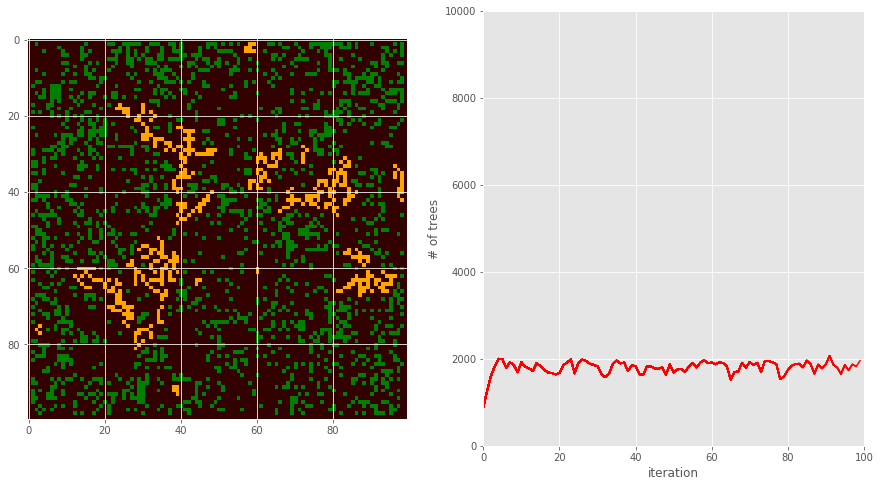

In [64]:
# Initialize the forest grid.
X  = np.zeros((ny, nx))

burned_list = run_simulation(X, 100, grow, ignite, burn)

## FFM Output Analysis

We can now analyze the burned areas produced by the FFM.
Let's plot the total burned area, iteration by iteration.

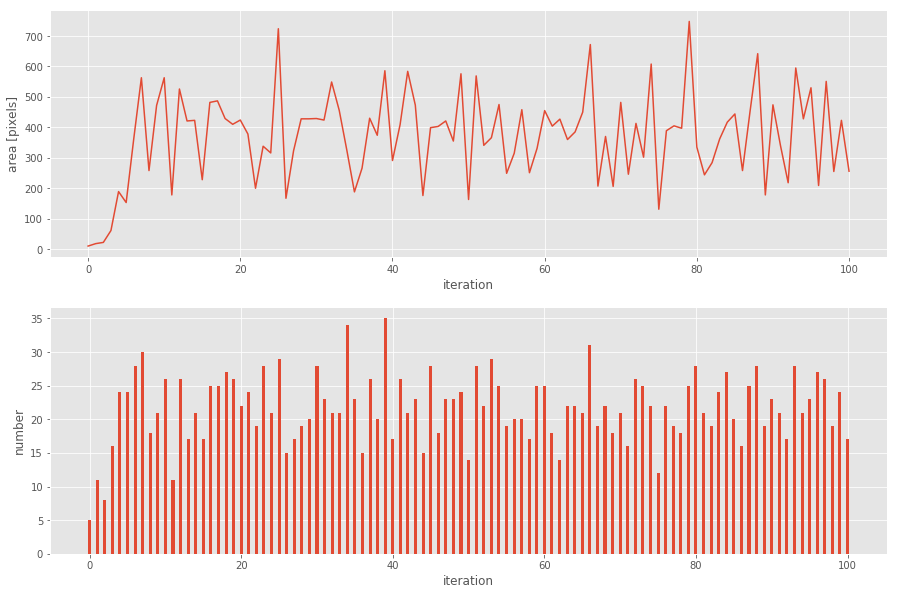

In [66]:
# for each element in the list, calculate the total area burned

tot_area_array, number_array = zip(*[(np.sum(b), len(b)) for b in burned_list])

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(tot_area_array)
plt.xlabel('iteration')
plt.ylabel('area [pixels]')

plt.subplot(2,1,2)
plt.bar(range(len(number_array)), number_array, width=0.4)
plt.xlabel('iteration')
plt.ylabel('number')

plt.show()

As expected, the total burned area and the number of wildfires varies quite a lot from one iteration to another.

## Power law

We expect the distribution of wildfires sizes to be shaped as a power-law distribution, e.g. in the form

\begin{equation*}
f(x)   =  \beta*x^{-\alpha}
\end{equation*}

Let's try to find if it is true
First, we have to transform the `burned_list` (which is a list of list) to a 1D array.
The `ffm_utils` package provides an useful function for that, `flattern`.

In [67]:
from utils.ffm_utils import flattern
flattern?

Signature: flattern(list_of_list)
Docstring: flatterns a list of list and return a 1D array
File:      ~/didattica/unige-wram-2018/notebooks/utils/ffm_utils.py
Type:      function


In [68]:
burned = flattern(burned_list)

Let's plot the histogram for the burned area. As expected, the distribution seems to be exponential, with a fat queue.

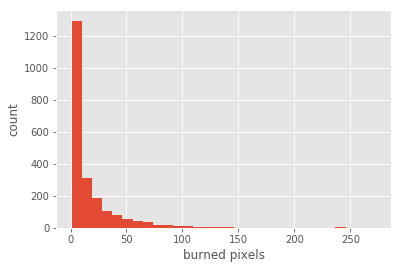

In [69]:
plt.hist(burned, bins=30)
plt.xlabel('burned pixels')
plt.ylabel('count')
plt.show()

Now, let's calculate the empirical distribution of the burned area.
First of all, we will calculate the histogram of the values, using an exponential bin spacing.
Let's plot it on a bilogaritmic axis

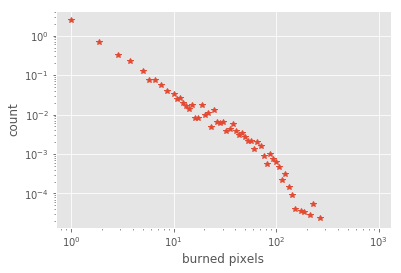

In [70]:
# Define the bins as linear in logarithmic space
bins = 10**np.linspace(0, 3, 100)

# Calculate the histogram and plot it 
# Note the density parameter. What is it used for?
hist, bins = np.histogram(burned, bins=bins, density=True)

plt.loglog(bins[:-1], hist, '*')
plt.xlabel('burned pixels')
plt.ylabel('count')
plt.show()

As expected, the distribution is close to a linear relation in the bi-logatirithmic space.
Now we can try to fit a linear regression to it, and extract the parameters.

First of all, let's extract the log value for both the bins and the values of the histogram.

Since some of the bins have no fires associated, we will have to remove them from the analysis

In [71]:
log_hist = np.log10(hist)
log_bin = np.log10(bins[:-1])

/Users/mirkodandrea/didattica/unige-wram-2018/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [72]:
log_hist, log_bin

(array([ 0.38528275,        -inf,        -inf,        -inf,        -inf,
               -inf,        -inf,        -inf,        -inf, -0.16327509,
               -inf,        -inf,        -inf,        -inf,        -inf,
        -0.49636095,        -inf,        -inf,        -inf, -0.63605647,
               -inf,        -inf,        -inf, -0.88854751,        -inf,
        -1.1126557 ,        -inf, -1.11526981,        -inf, -1.25942193,
               -inf, -1.41529605,        -inf, -1.47590211, -1.60723172,
        -1.57954281, -1.71130348, -1.77732206, -1.86033144, -1.76921231,
        -2.0900799 , -2.08087439, -1.74862939, -2.01184659, -1.96530959,
        -2.30854184, -1.8865472 , -2.17726238, -2.20756541, -2.19366477,
        -2.4142995 , -2.36542129, -2.23186752, -2.40829858, -2.51432233,
        -2.46890464, -2.57492839, -2.67217821, -2.67900014, -2.87411342,
        -2.69614051, -2.79339033, -3.03757318, -3.26417085, -2.99344389,
        -3.12848227, -3.20017798, -3.32739103, -3.6

In [73]:
# find the bins for which the log is not -inf
valid_bins = log_hist!= -np.inf

# let's use only the valid ones
log_hist_valid = log_hist[valid_bins]
log_bin_valid = log_bin[valid_bins]

We can now interpolate the values using the `linregress` function from the `scipy` library.

In [74]:
from scipy.stats import linregress
linregress?

Signature: linregress(x, y=None)
Docstring:
Calculate a linear least-squares regression for two sets of measurements.

Parameters
----------
x, y : array_like
    Two sets of measurements.  Both arrays should have the same length.
    If only x is given (and y=None), then it must be a two-dimensional
    array where one dimension has length 2.  The two sets of measurements
    are then found by splitting the array along the length-2 dimension.

Returns
-------
slope : float
    slope of the regression line
intercept : float
    intercept of the regression line
rvalue : float
    correlation coefficient
pvalue : float
    two-sided p-value for a hypothesis test whose null hypothesis is
    that the slope is zero, using Wald Test with t-distribution of
    the test statistic.
stderr : float
    Standard error of the estimated gradient.

See also
--------
:func:`scipy.optimize.curve_fit` : Use non-linear
 least squares to fit a function to data.
:func:`scipy.optimize.leastsq` : Minimize t

In [61]:
fit = linregress(log_bin_valid, log_hist_valid)
print(
"""linear regression parameters: 
    alpha = %s 
    beta = %s
    rvalue = %s
    """
    %(fit.slope, fit.intercept, fit.rvalue)
)

linear regression parameters: 
    alpha = -1.988450462616984 
    beta = 0.546524272756129
    rvalue = -0.9791173411232863
    


We can now plot again the interpolated relation and the empirical distribution.

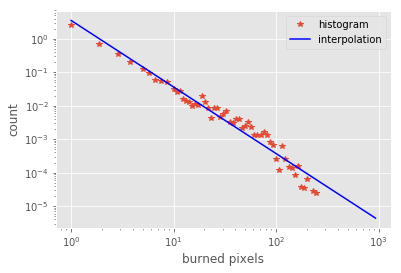

In [62]:
interp_line = 10**(fit.intercept + np.log10(bins[:-1]) * fit.slope)

plt.loglog(bins[:-1], hist, '*', label='histogram')
plt.loglog(bins[:-1], interp_line, 'b', label='interpolation')
plt.xlabel('burned pixels')
plt.ylabel('count')
plt.legend()
plt.show()

## Excercise 1
Explore the parameter space of the model, and try to figure out the relation between those and the distribution of the events

## Excercise 2

Make a duplicate of this notebook and try to modify the model by yourself according to one or more of this criteria:

1) add a probability of fire propagation between cells

2) add 2 different vegetation classes, with different probabilities of ignition, regrowth and fire transition

3) make the vegetation evolve from one class to the other
